# Bayesian Optimisation Overview

1. General Overview
2. Gaussian Processes
3. Acquisition function
4. Example with GPy

General Overview

Bayesian Inference (Short)

GP - distributions over functions

> Sounds complicated, but only evaluated at a finite set of points
> Can be derived from Bayesian linear regression



## Gaussian Processes
https://www.cs.toronto.edu/~duvenaud/cookbook/

In [51]:
# Mu is assumed to be a zero function
# Kernel function squared exponential kernel

import numpy as np
import matplotlib.pyplot as plt

def squared_exponential_kernel(x1, x2, sigma = 1., l = .1):
    return sigma**2 * np.exp(-((x1-x2)**2)/(2*l**2))
    
def linear_kernel(x1, x2, sigma_b = .1, sigma_v = .1, c = -1):
    return sigma_b**2 + sigma_v**2 * (x1-c)*(x2-c)  
    
    
def periodic_kernel(x1, x2, sigma = 1., l = 1., p = 1.):
    return sigma**2 * np.exp(-2*(np.sin(np.pi*abs(x1-x2)/p)**2)/(l**2))

In [5]:
data = np.linspace(-5, 5, 100)

In [7]:
for (i,j) in data@data:
    linear_kernel(i,j)

TypeError: 'numpy.float64' object is not iterable

In [52]:
kernel_vals = list(map(periodic_kernel, data, np.zeros(100)))


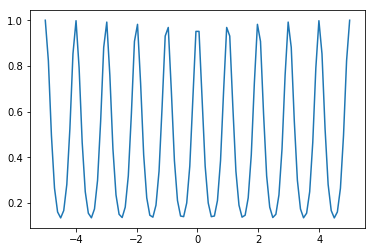

In [53]:
plt.plot(data,kernel_vals);plt.show()

In [25]:
kernel_vals

[0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 0.01000000